# Measure the Difference between Preprint-Published similarity and Published Articles

This notebook measures the time delay that results from the peer review process. Two plots are generated: one that depict the average publication time delay as changes are demanded from the peer review process and the other that depicts the added time delay as preprints have to undergo multiple versions to be published.

In [1]:
from datetime import timedelta
import random
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import ConnectionPatch

mpl.rcParams["figure.dpi"] = 250

import numpy as np
import pandas as pd
import plotnine as p9
import requests
from scipy.spatial.distance import cdist
from scipy.stats import linregress
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
import tqdm

from mizani.breaks import date_breaks
from mizani.formatters import timedelta_format

import warnings

warnings.filterwarnings("ignore")

# Load the Document Distances

In [2]:
published_date_distances = pd.read_csv(
    "../../pmc/word_vector_experiment/output/preprint_published_distances.csv"
)
for col in ["preprint_date", "published_date"]:
    published_date_distances[col] = pd.to_datetime(published_date_distances[col])
published_date_distances["time_to_published"] = pd.to_timedelta(
    published_date_distances["time_to_published"]
)
print(published_date_distances.shape)
published_date_distances.head()

(17527, 12)


,preprint_doi,document,category,version_count,published_doi,pmcid,pmcoa,journal,preprint_date,published_date,time_to_published,doc_distances
0,10.1101/000026,000026_v1.xml,genetics,1,10.1371/journal.pgen.1004412,PMC4125079,True,PLoS_Genet,2013-11-07,2014-08-07,273 days,1.640911
1,10.1101/000067,000067_v1.xml,genomics,1,10.1038/nature12904,PMC4285441,True,Nature,2013-11-07,2014-02-27,112 days,1.683717
2,10.1101/000109,000109_v1.xml,evolutionary biology,1,10.1371/journal.pgen.1004410,PMC4072524,True,PLoS_Genet,2013-11-07,2014-06-26,231 days,1.244658
3,10.1101/000141,000141_v1.xml,cancer biology,1,10.1371/journal.pcbi.1003433,PMC3894166,True,PLoS_Comput_Biol,2013-11-07,2014-01-16,70 days,0.972641
4,10.1101/000158,000158_v1.xml,bioinformatics,1,10.1186/1471-2164-15-398,PMC4041996,True,BMC_Genomics,2013-11-11,2014-05-24,194 days,1.077589


In [3]:
published_date_distances["days_to_published"] = published_date_distances[
    "time_to_published"
].dt.days

In [4]:
remove_negative_time_to_published = True
if remove_negative_time_to_published:
    published_date_distances = published_date_distances[
        published_date_distances["days_to_published"] >= 0
    ]

# Construct Scatter Plot of Date vs Version Count

Preprints are delayed on an average of 51 days for each new version posted onto bioRxiv. This section regresses preprint's version counts against the time it takes to have a preprint published. A scatter and square bin plot are generated below.

In [5]:
# Get smoothed linear regression line
x = published_date_distances.version_count.values.tolist()

y = published_date_distances.time_to_published.apply(
    lambda x: x / timedelta(days=1)
).tolist()

xseq_2 = np.linspace(np.min(x), np.max(x), 80)

results_2 = linregress(x, y)
print(results_2)

LinregressResult(slope=50.67308073983789, intercept=133.5346031692294, rvalue=0.30382607616433754, pvalue=0.0, stderr=1.2010600586705775)


In [6]:
x_line = np.array(
    [
        published_date_distances["version_count"].min(),
        published_date_distances["version_count"].max(),
    ]
)
y_line = x_line * results_2.slope + results_2.intercept

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


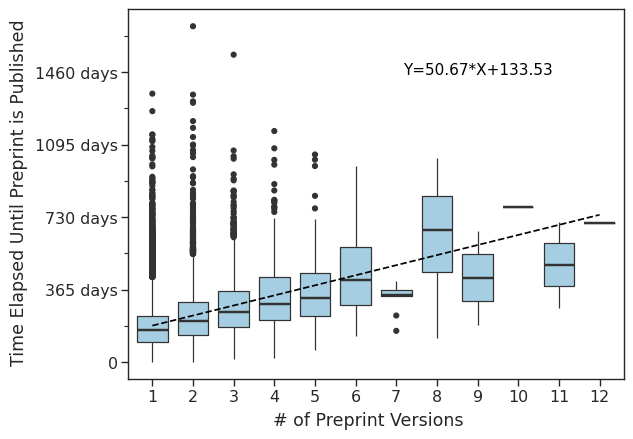

<ggplot: (8775530837810)>


In [7]:
g = (
    p9.ggplot(
        published_date_distances,
        p9.aes(x="factor(version_count)", y="time_to_published"),
    )
    + p9.geom_boxplot(fill="#a6cee3")
    + p9.geom_line(
        mapping=p9.aes(x="version_count", y="time_to_published"),
        stat="smooth",
        method="lm",
        linetype="dashed",
        se=False,
        alpha=1,
        size=0.7,
        inherit_aes=False,
    )
    + p9.scale_y_timedelta(labels=timedelta_format("d"))
    + p9.annotate(
        "text",
        x=9,
        y=timedelta(days=1470),
        label=f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}",
    )
    + p9.labs(x="# of Preprint Versions", y="Time Elapsed Until Preprint is Published")
    + p9.theme_seaborn(context="paper", style="ticks", font="Arial", font_scale=1.3)
)
# g.save("output/version_count_vs_publication_time.svg", dpi=500)
# g.save("output/version_count_vs_publication_time.png", dpi=500)
print(g)

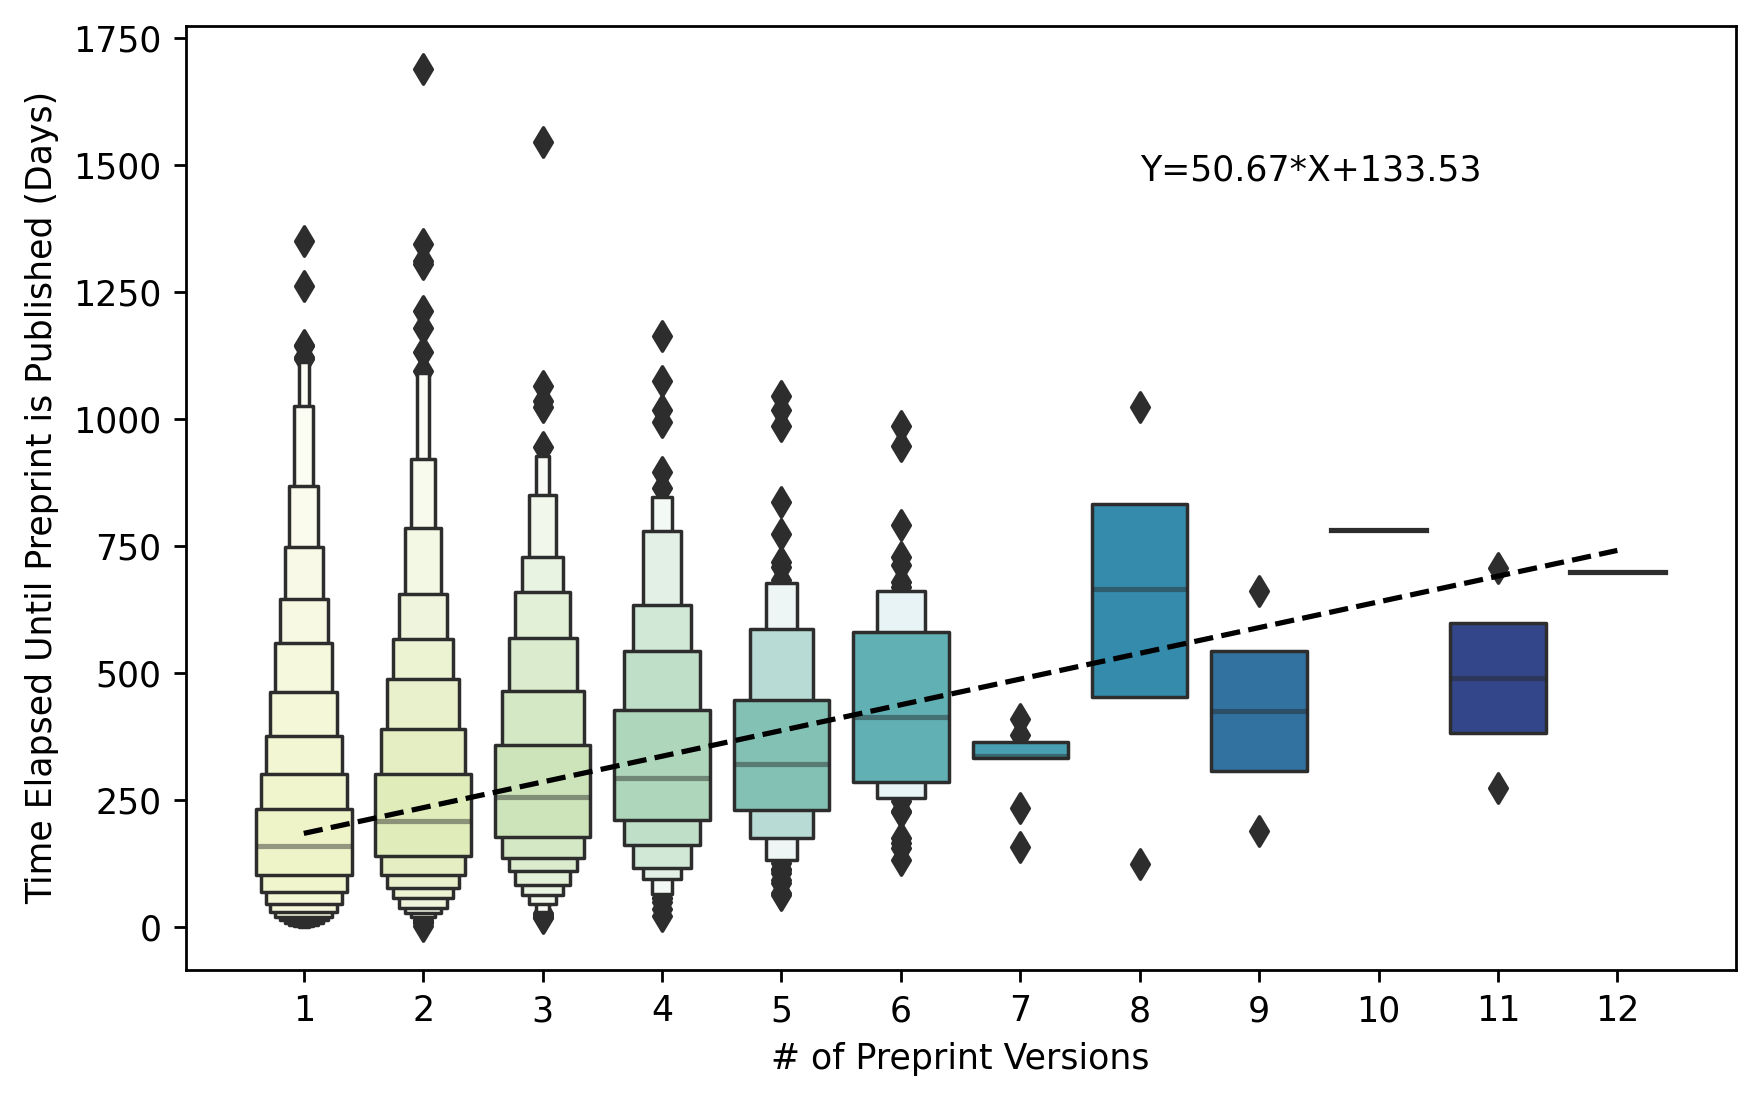

In [8]:
plt.figure(figsize=(8, 5))
g = sns.boxenplot(
    x="version_count",
    y="days_to_published",
    data=published_date_distances,
    scale="linear",
    palette="YlGnBu",
)
_ = g.set_ylabel("Time Elapsed Until Preprint is Published (Days)")
_ = g.set_xlabel("# of Preprint Versions")
_ = g.plot(x_line - 1, y_line, "--k")
_ = g.annotate(f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}", (7, 1470))

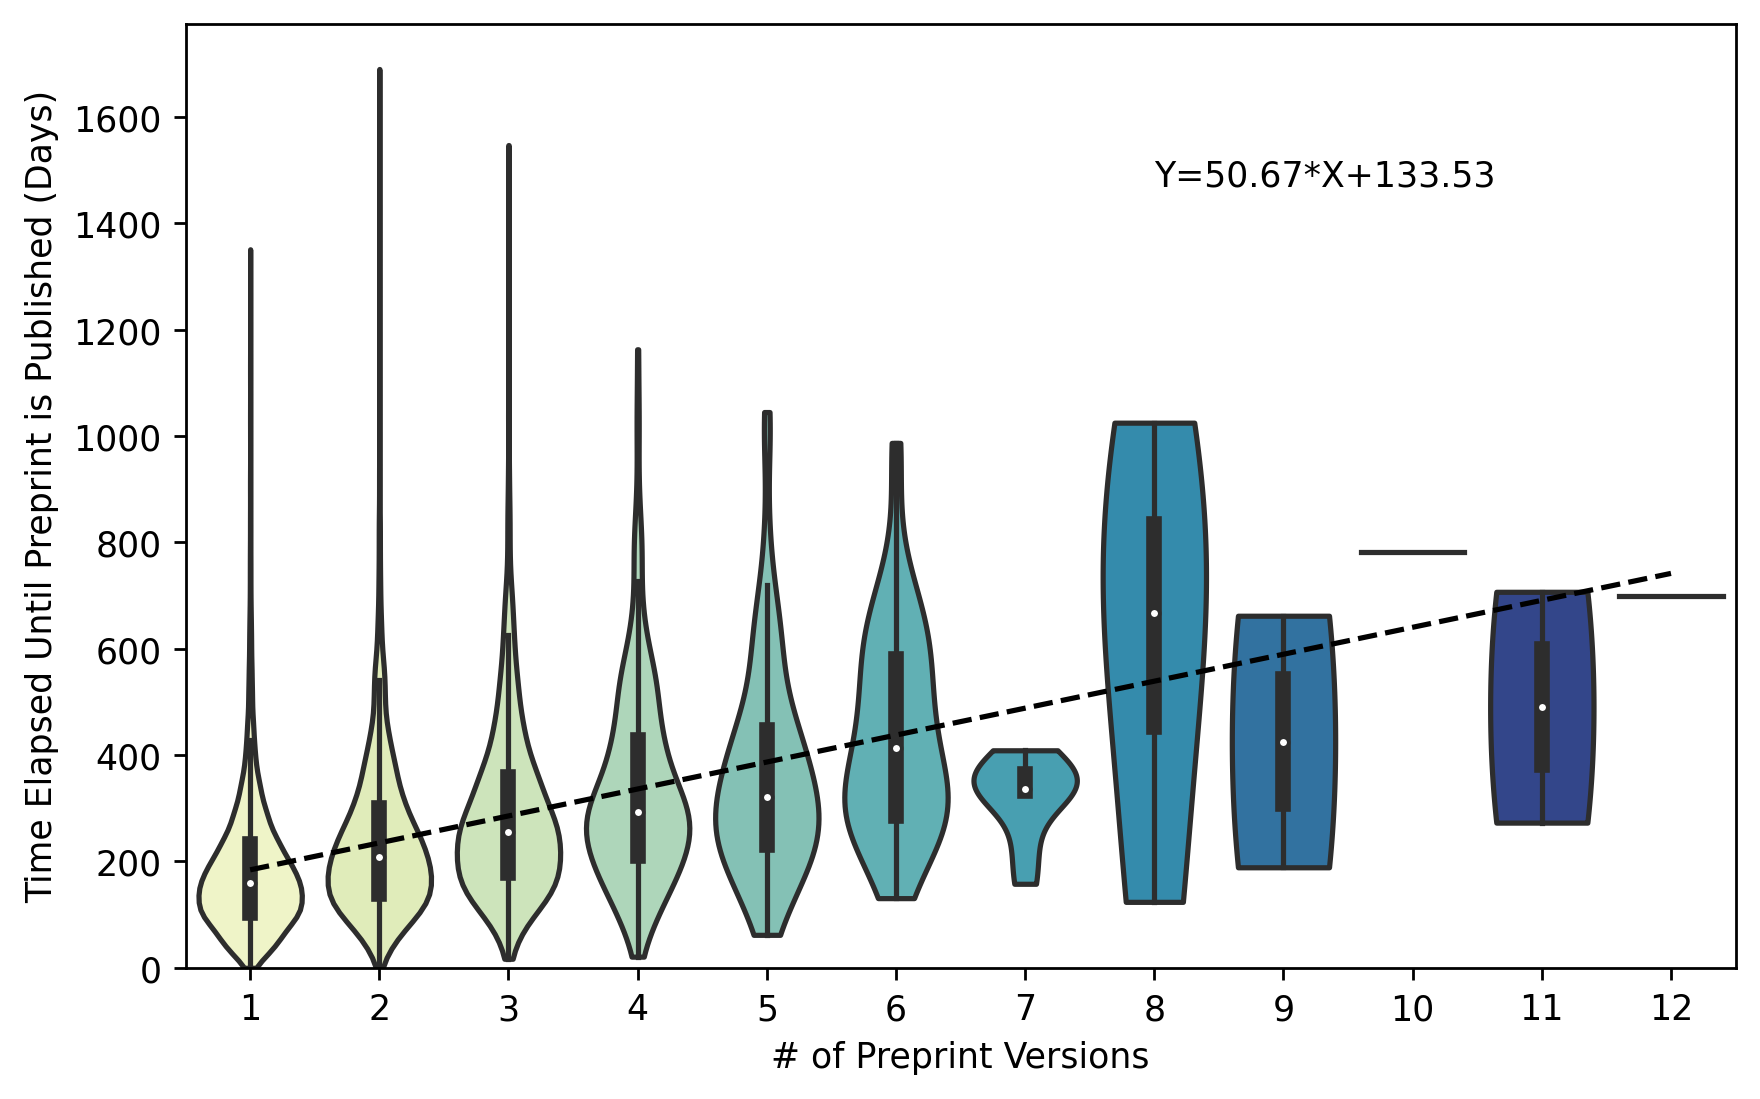

In [9]:
plt.figure(figsize=(8, 5))
g = sns.violinplot(
    x="version_count",
    y="days_to_published",
    data=published_date_distances,
    cut=0,
    scale="width",
    palette="YlGnBu",
)
_ = g.set_ylabel("Time Elapsed Until Preprint is Published (Days)")
_ = g.set_xlabel("# of Preprint Versions")
_ = g.plot(x_line - 1, y_line, "--k")
_ = g.annotate(f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}", (7, 1470))
_ = g.set_xlim(-.5, 11.5)
_ = g.set_ylim(0, g.get_ylim()[1])
plt.savefig("output/version_count_vs_publication_time_violin.svg", dpi=500)
plt.savefig("output/version_count_vs_publication_time_violin.png", dpi=500)

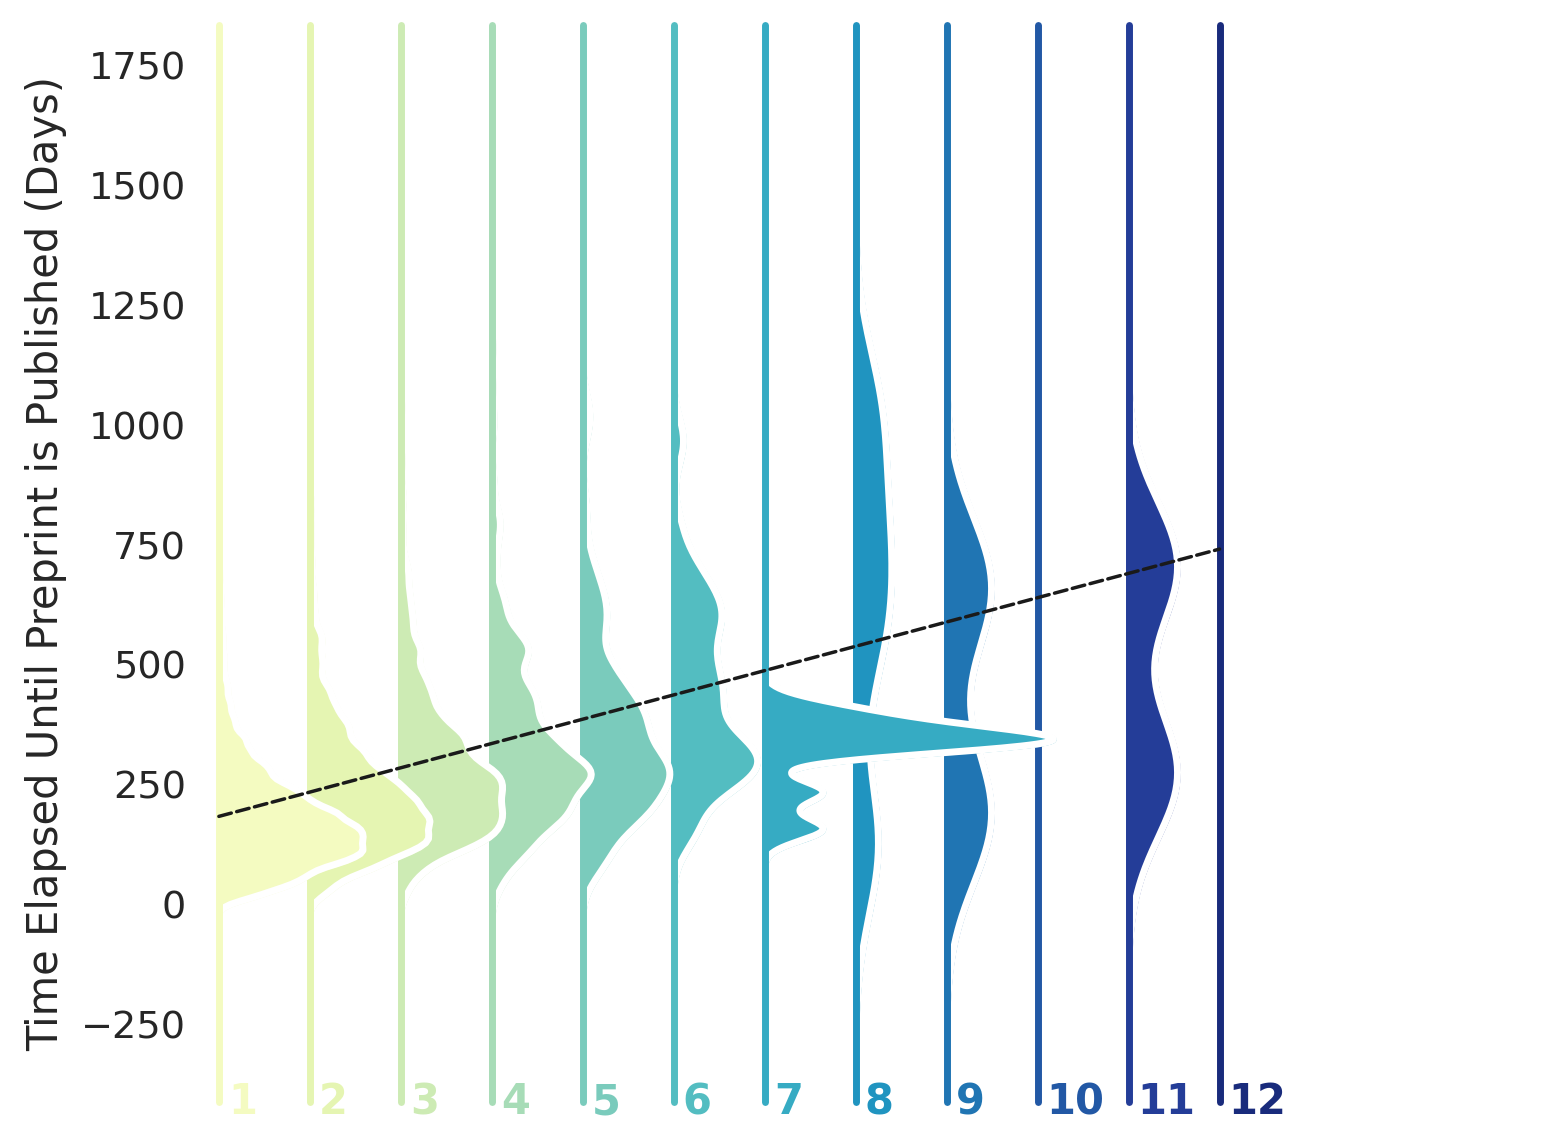

In [10]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

bw_adjust = 0.5

g = sns.FacetGrid(
    published_date_distances,
    col="version_count",
    hue="version_count",
    aspect=0.1,
    height=5,
    palette="YlGnBu",
)

# Draw the densities in a few steps
g = g.map(
    sns.kdeplot,
    "days_to_published",
    vertical=True,
    bw_adjust=bw_adjust,
    clip_on=False,
    fill=True,
    alpha=1,
    linewidth=1.5,
)

g = g.map(
    sns.kdeplot,
    "days_to_published",
    clip_on=False,
    color="w",
    lw=2,
    bw_adjust=bw_adjust,
    vertical=True,
)
g = g.map(plt.axvline, x=0, lw=2, clip_on=False)

# reorder so right side is lower than left
for i, ax in enumerate(g.axes[0]):
    ax.set_zorder(ax.zorder - i)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(
        0.03,
        0,
        label,
        fontweight="bold",
        color=color,
        ha="left",
        va="center",
        transform=ax.transAxes,
    )


_ = g.map(label, "days_to_published")

_ = g.set_ylabels("Time Elapsed Until Preprint is Published (Days)")
_ = g.set_xlabels("")

xyA = (0, y_line[0])
xyB = (0, y_line[1])
axA = g.axes[0][0]
axB = g.axes[0][-1]
line = ConnectionPatch(
    xyA=xyA,
    coordsA=axA.transData,
    xyB=xyB,
    coordsB=axB.transData,
    linestyle="--",
    color="k",
)
_ = g.fig.add_artist(line)

# Set the subplots to overlap
_ = g.fig.subplots_adjust(wspace=-0.7)

# Remove axes details that don't play well with overlap
_ = g.set_titles("")
_ = g.set(xticks=[])
_ = g.despine(bottom=True, left=True)

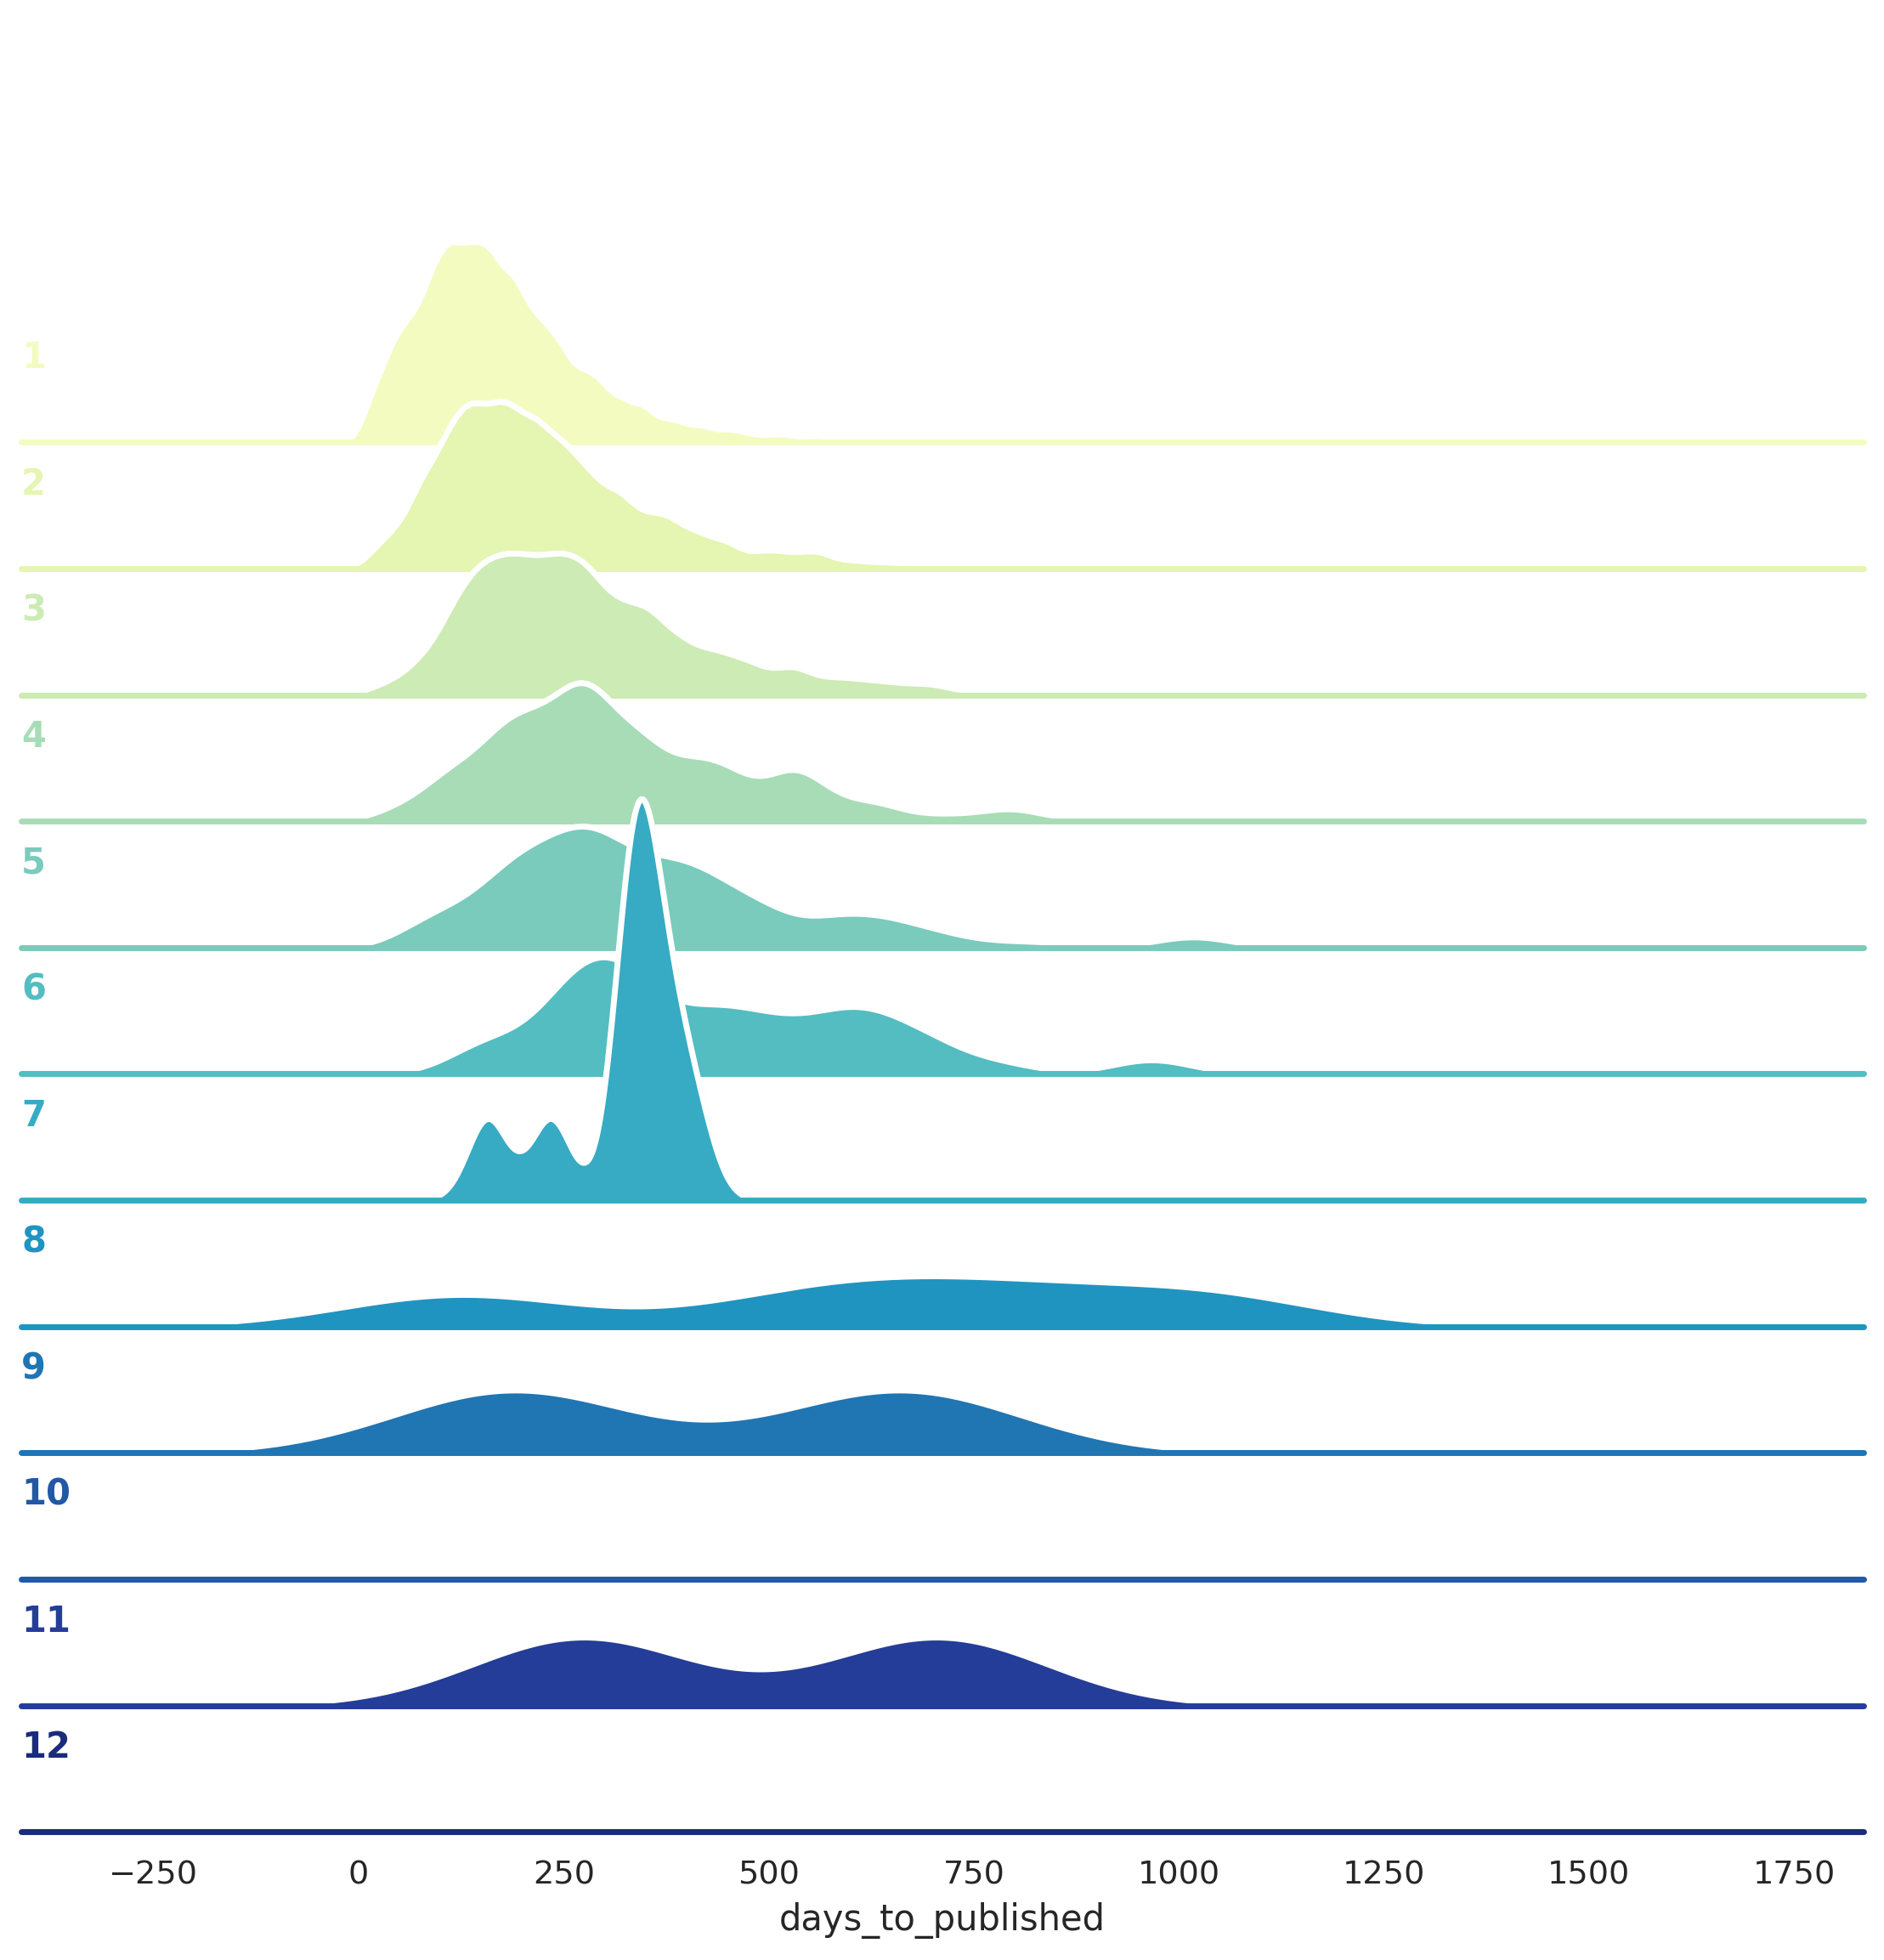

In [11]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(
    published_date_distances,
    row="version_count",
    hue="version_count",
    aspect=12,
    height=0.8,
    palette="YlGnBu",
)

# Draw the densities in a few steps
g.map(
    sns.kdeplot,
    "days_to_published",
    bw_adjust=0.5,
    clip_on=False,
    fill=True,
    alpha=1,
    linewidth=1.5,
)
g.map(
    sns.kdeplot, "days_to_published", clip_on=False, color="w", lw=2, bw_adjust=0.5,
)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(
        0,
        0.2,
        label,
        fontweight="bold",
        color=color,
        ha="left",
        va="center",
        transform=ax.transAxes,
    )


g.map(label, "days_to_published")

# g.set_xlabels("Diversity (1 - gini coefficient)")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-0.7)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

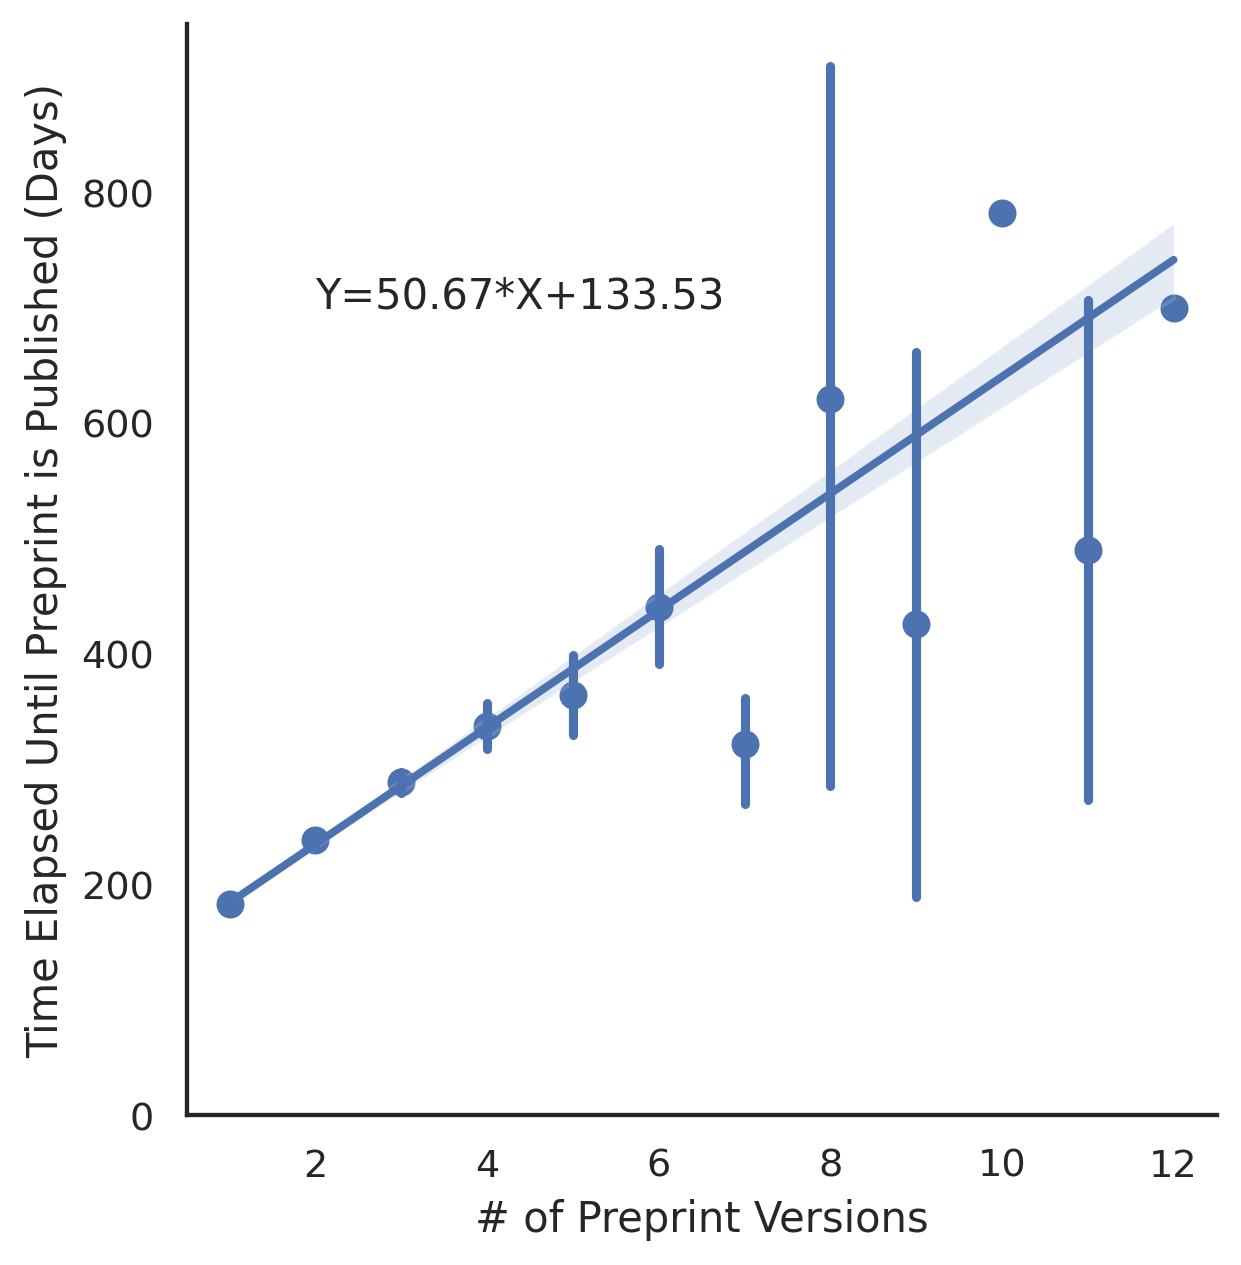

In [12]:
g = sns.lmplot(
    x="version_count",
    y="days_to_published",
    data=published_date_distances,
    x_bins=np.unique(x),
    palette="YlGnBu",
)
_ = g.set_ylabels("Time Elapsed Until Preprint is Published (Days)")
_ = g.set_xlabels("# of Preprint Versions")
_ = g.axes[0][0].annotate(f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}", (2, 700))
_ = g.axes[0][0].set_xlim(.5, 12.5)
_ = g.axes[0][0].set_ylim(0, g.axes[0][0].get_ylim()[1])

# Construct Scatter Plot of Date vs Document Distances

Preprints are delayed on an average of 17 days as changes are demanded from the peer-review process. This section regresses a preprint's document distance against the time it takes to have a preprint published. A scatter and square bin plot are generated below.

In [13]:
# Get smoothed linear regression line
x = published_date_distances.doc_distances.values.tolist()

y = published_date_distances.time_to_published.apply(
    lambda x: x / timedelta(days=1)
).tolist()

xseq_2 = np.linspace(np.min(x), np.max(x), 80)

results_2 = linregress(x, y)
print(results_2)

LinregressResult(slope=16.28175395734407, intercept=185.4275442609044, rvalue=0.09299011747374086, pvalue=6.319875464935862e-35, stderr=1.317717373527493)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


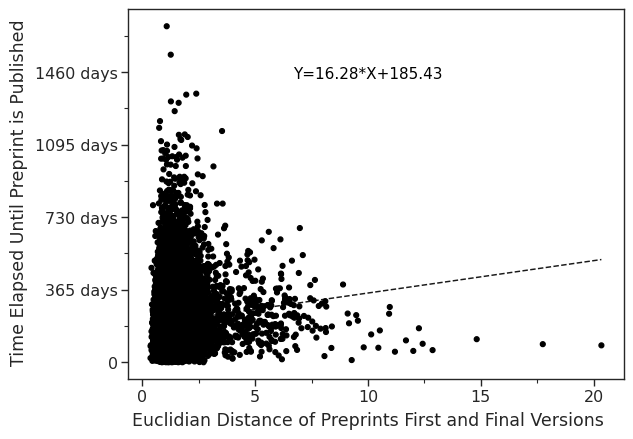

<ggplot: (-9223363261325319336)>


In [14]:
g = (
    p9.ggplot(
        published_date_distances, p9.aes(y="time_to_published", x="doc_distances")
    )
    + p9.geom_point()
    + p9.geom_line(
        stat="smooth", method="lm", linetype="dashed", se=False, alpha=0.9, size=0.6
    )
    + p9.scale_y_timedelta(labels=timedelta_format("d"))
    + p9.annotate(
        "text",
        x=10,
        y=timedelta(days=1450),
        label=f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}",
    )
    + p9.labs(
        x="Euclidian Distance of Preprints First and Final Versions",
        y="Time Elapsed Until Preprint is Published",
    )
    + p9.theme_seaborn(context="paper", style="ticks", font="Arial", font_scale=1.3)
)
print(g)

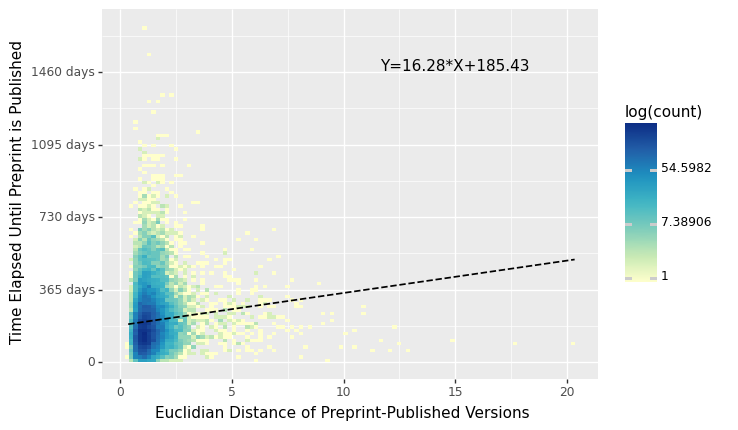

<ggplot: (-9223363261323927941)>


In [15]:
g = (
    p9.ggplot(
        published_date_distances, p9.aes(x="doc_distances", y="time_to_published")
    )
    + p9.geom_bin2d(bins=100)
    + p9.scale_fill_distiller(
        trans="log", direction=-1, type="seq", palette="YlGnBu", name="log(count)"
    )
    + p9.geom_line(
        stat="smooth", method="lm", linetype="dashed", se=False, alpha=1, size=0.7
    )
    + p9.scale_y_timedelta(labels=timedelta_format("d"))
    + p9.annotate(
        "text",
        x=15,
        y=timedelta(days=1490),
        label=f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}",
    )
    + p9.labs(
        x="Euclidian Distance of Preprint-Published Versions",
        y="Time Elapsed Until Preprint is Published",
        legend="log(count)",
    )
)
# g.save("output/article_distance_vs_publication_time.svg", dpi=250)
# g.save("output/article_distance_vs_publication_time.png", dpi=250)
print(g)

# Hex grid options
A couple hex grid options just to see what they look like

In [16]:
x_line = np.array(
    [
        published_date_distances["doc_distances"].min(),
        published_date_distances["doc_distances"].max(),
    ]
)
y_line = x_line * results_2.slope + results_2.intercept

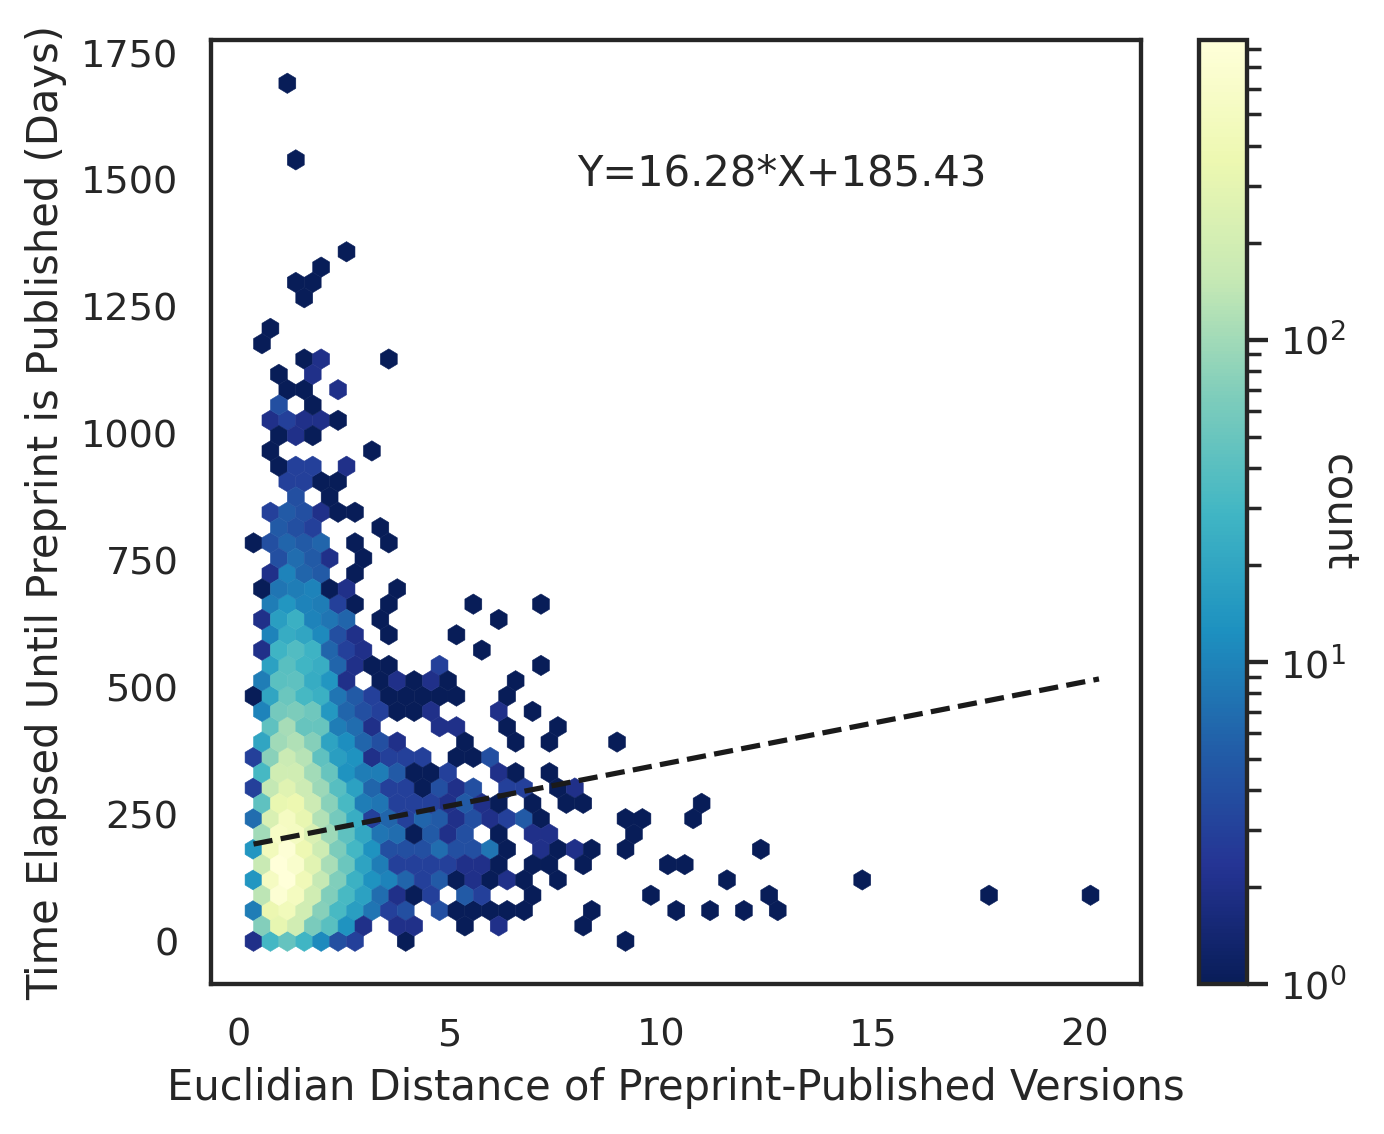

In [17]:
plt.figure(figsize=(6, 5))
ax = plt.hexbin(
    published_date_distances["doc_distances"],
    published_date_distances["days_to_published"],
    gridsize=50,
    cmap="YlGnBu_r",
    norm=mpl.colors.LogNorm(),
    mincnt=1,
    linewidths=(0.15,)
    #     edgecolors=None
)
ax = plt.gca()
ax.plot(x_line, y_line, "--k")
ax.annotate(
    f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}", (8, 1490),
)
_ = ax.set_xlabel("Euclidian Distance of Preprint-Published Versions")
_ = ax.set_ylabel("Time Elapsed Until Preprint is Published (Days)")
cbar = plt.colorbar()
_ = cbar.ax.set_ylabel("count", rotation=270)
plt.savefig("output/article_distance_vs_publication_time_hex.svg", dpi=250)
plt.savefig("output/article_distance_vs_publication_time_hex.png", dpi=250)

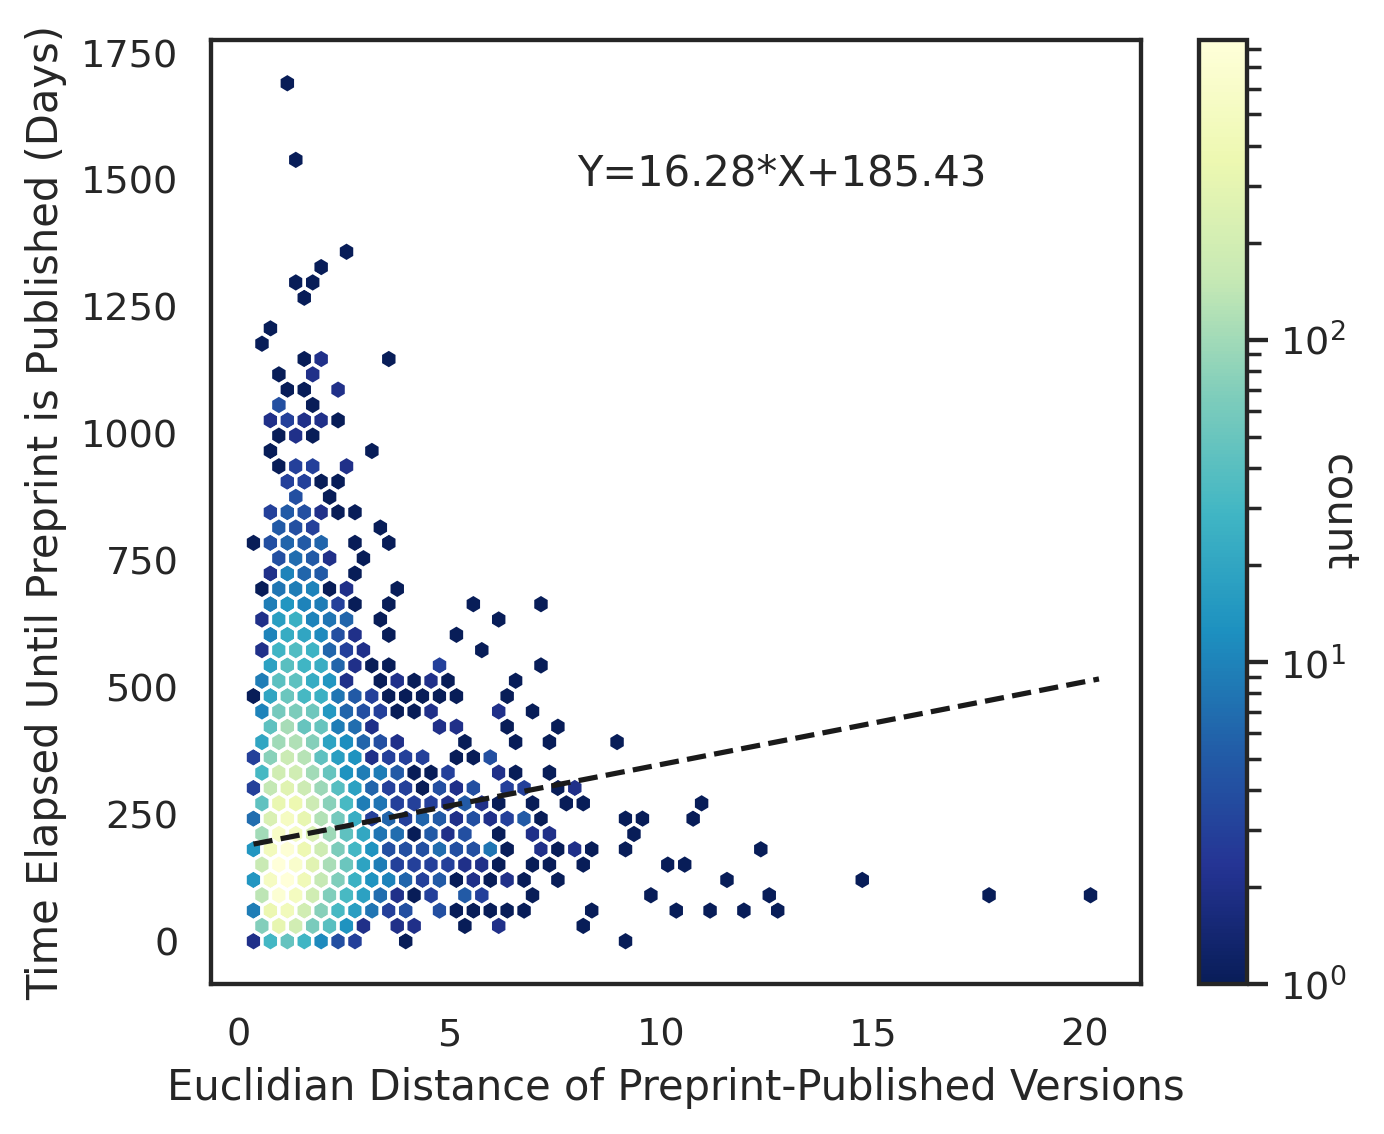

In [18]:
plt.figure(figsize=(6, 5))
ax = plt.hexbin(
    published_date_distances["doc_distances"],
    published_date_distances["days_to_published"],
    gridsize=50,
    cmap="YlGnBu_r",
    norm=mpl.colors.LogNorm(),
    mincnt=1,
    edgecolors=None,
)
ax = plt.gca()
ax.plot(x_line, y_line, "--k")
ax.annotate(
    f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}", (8, 1490),
)
_ = ax.set_xlabel("Euclidian Distance of Preprint-Published Versions")
_ = ax.set_ylabel("Time Elapsed Until Preprint is Published (Days)")
cbar = plt.colorbar()
_ = cbar.ax.set_ylabel("count", rotation=270)

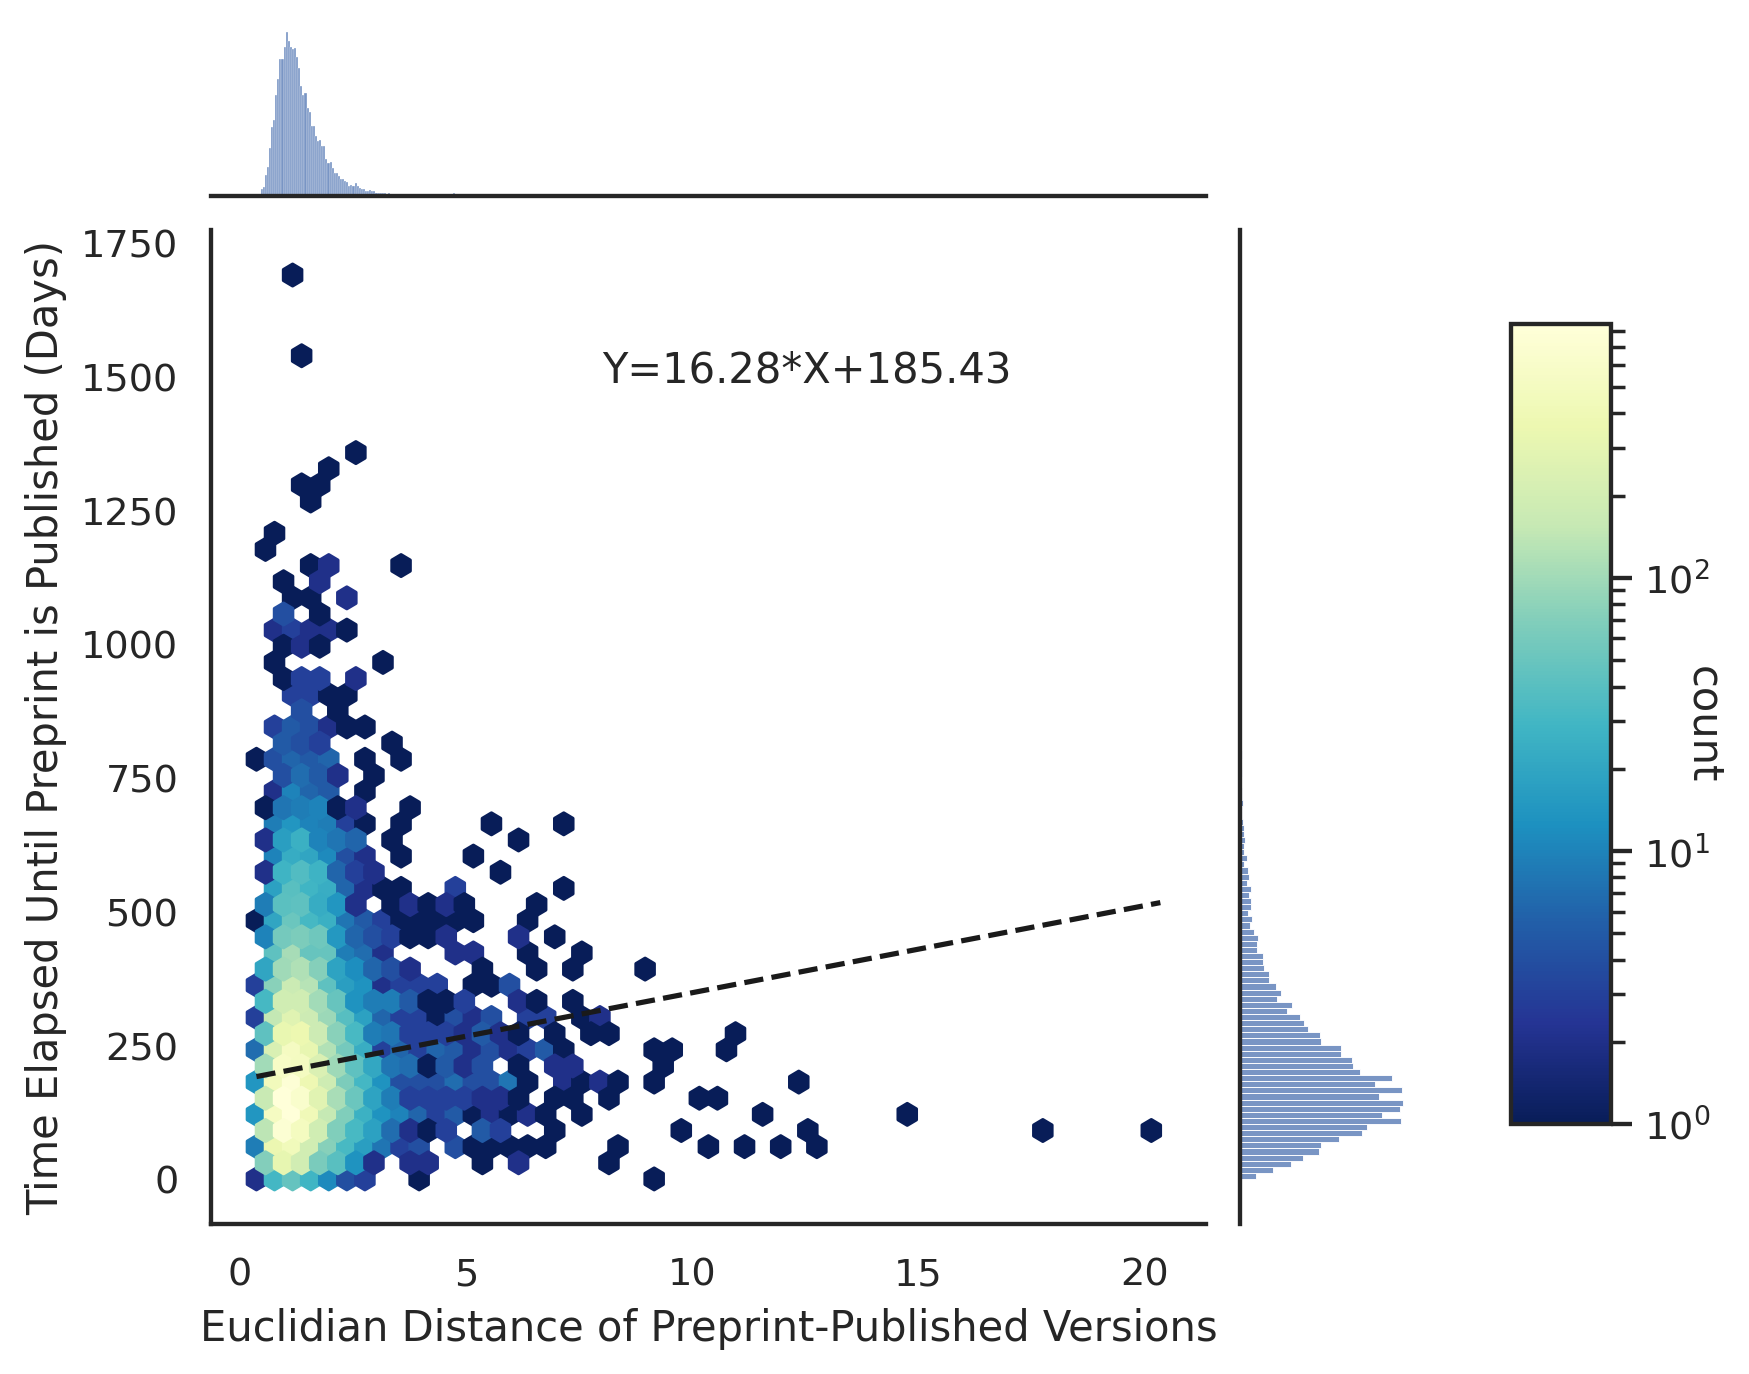

In [19]:
hexplot = sns.jointplot(
    x="doc_distances",
    y="days_to_published",
    data=published_date_distances,
    kind="hex",
    joint_kws={"cmap": "YlGnBu_r", "mincnt": 1},
    norm=mpl.colors.LogNorm(),
    height=8,
)

hexplot.set_axis_labels(
    xlabel="Euclidian Distance of Preprint-Published Versions",
    ylabel="Time Elapsed Until Preprint is Published (Days)",
)

hexplot.ax_joint.plot(x_line, y_line, "--k")
hexplot.ax_joint.annotate(
    f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}", (8, 1490),
)
# shrink fig so cbar is visible
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
# make new ax object for the cbar
cbar_ax = hexplot.fig.add_axes([0.85, 0.25, 0.05, 0.4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
_ = cbar_ax.set_ylabel("count", rotation=270)

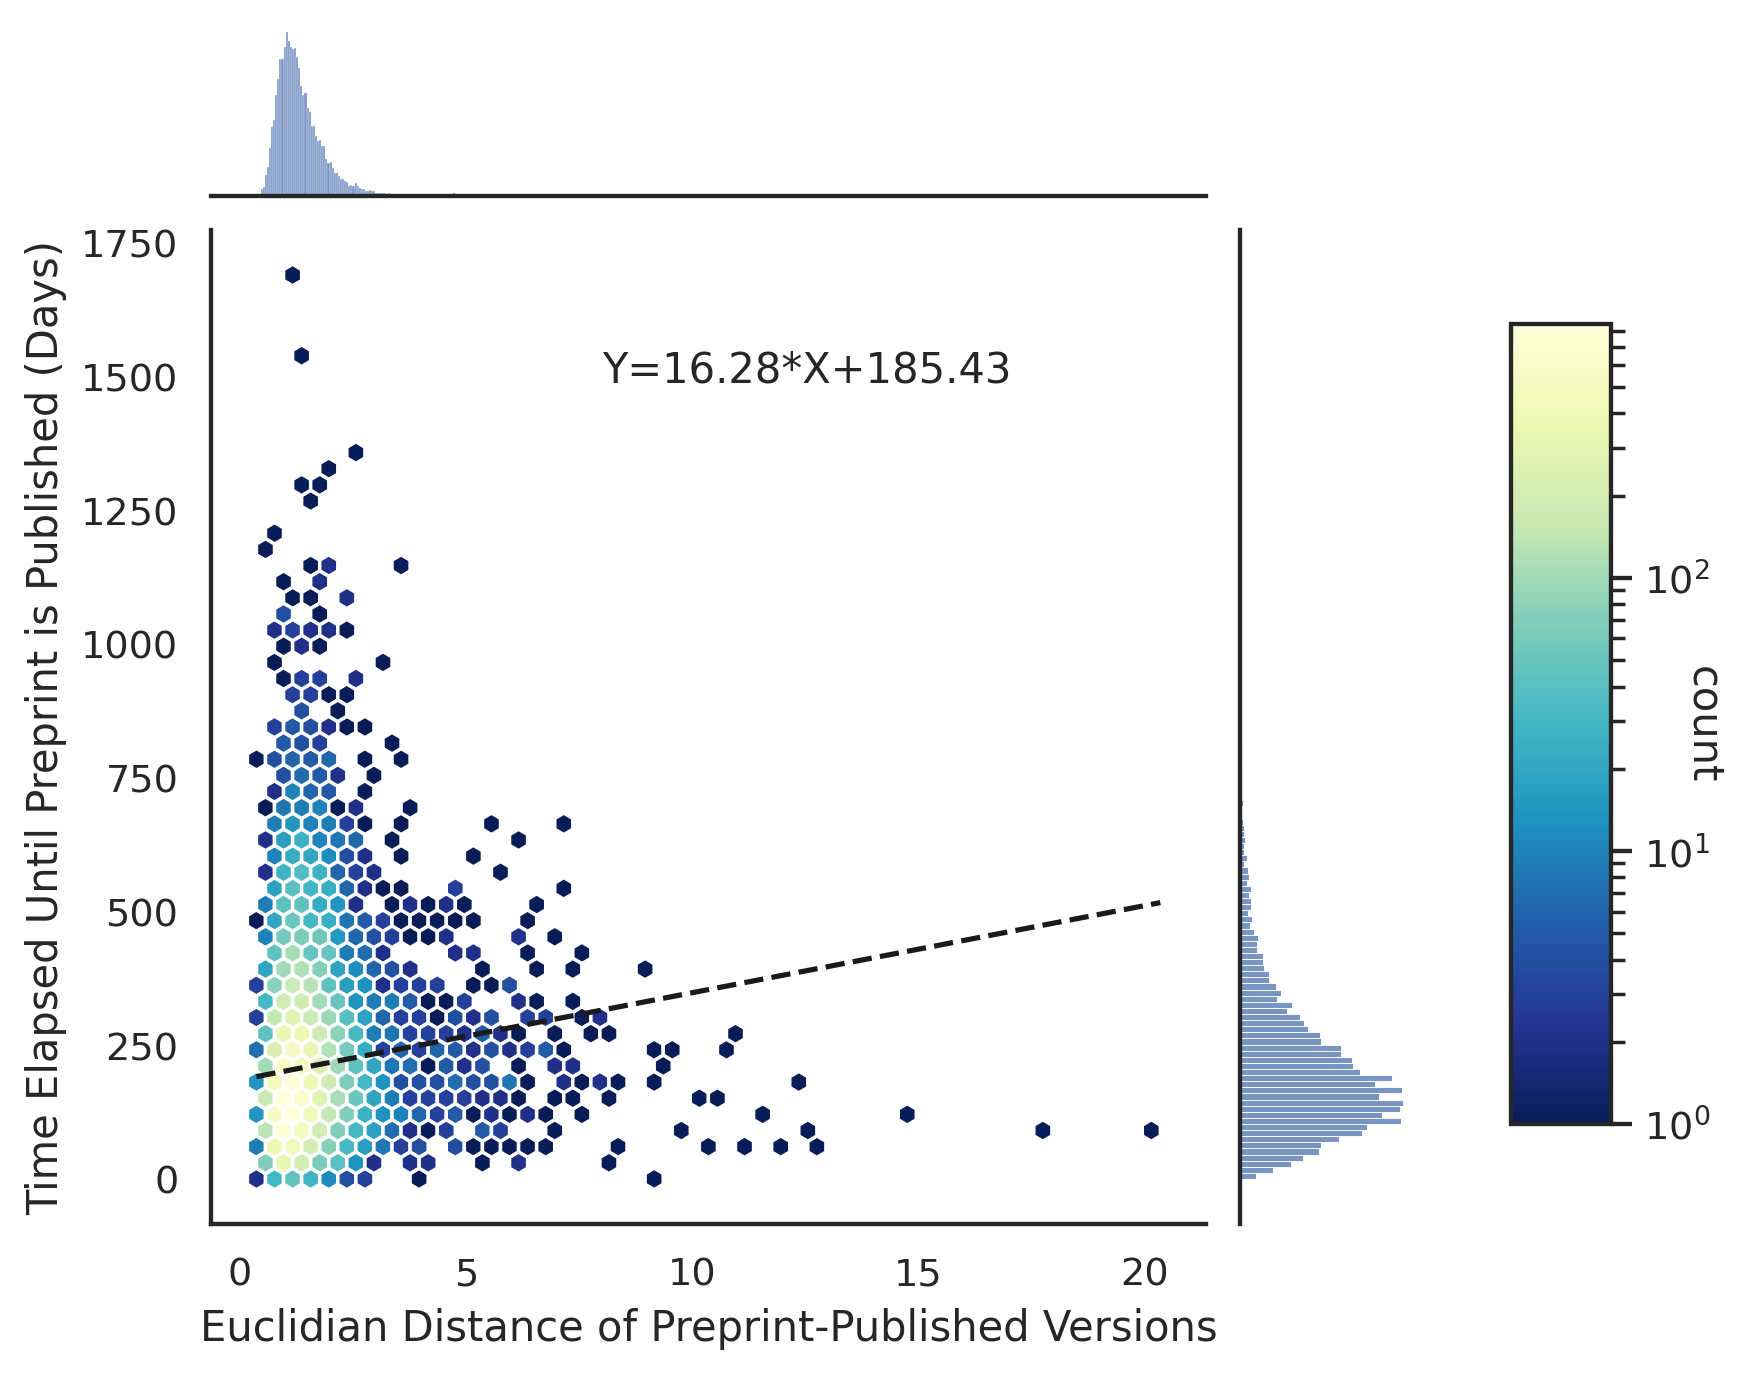

In [20]:
hexplot = sns.jointplot(
    x="doc_distances",
    y="days_to_published",
    data=published_date_distances,
    kind="hex",
    joint_kws={"cmap": "YlGnBu_r", "mincnt": 1, "edgecolors": None},
    norm=mpl.colors.LogNorm(),
    height=8,
)

hexplot.set_axis_labels(
    xlabel="Euclidian Distance of Preprint-Published Versions",
    ylabel="Time Elapsed Until Preprint is Published (Days)",
)

hexplot.ax_joint.plot(x_line, y_line, "--k")
hexplot.ax_joint.annotate(
    f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}", (8, 1490),
)
# shrink fig so cbar is visible
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
# make new ax object for the cbar
cbar_ax = hexplot.fig.add_axes([0.85, 0.25, 0.05, 0.4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
_ = cbar_ax.set_ylabel("count", rotation=270)